## Cats and dogs Selectivenet

In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import seed
seed(3)
tf.random.set_seed(3)

import tensorflow as tf
import numpy as np
import os
import pathlib
# import pickle
# from tensorflow.keras import backend as K
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from catdog_vgg_selectivenet import *

### Load data

In [2]:
def split(n,split_ratio):    
    rng=np.random.default_rng() #for reproducibility
    random_idx = rng.choice(n, size=n, replace=False) # returns a numpy array, shuffles the index based on n   
    split1_end = int(split_ratio[1]*n)
    
    split1_idx = random_idx[:split1_end]
    split2_idx = random_idx[split1_end:]
    return split1_idx, split2_idx 

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(validation_dir)

/home/evelynanyebe/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
# os.getcwd()

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print(total_train)

2000


In [7]:
tr_cats = np.char.add( np.repeat([train_cats_dir+'/'],num_cats_tr),np.array(os.listdir(train_cats_dir)) )                    
tr_dogs = np.char.add( np.repeat([train_dogs_dir+'/'],num_dogs_tr),np.array(os.listdir(train_dogs_dir)) )
tr_cats_labels =  np.zeros([num_cats_tr,2])              
tr_dogs_labels =  np.zeros([num_dogs_tr,2])
tr_dogs_labels[:, 1] = 1
tr_cats_labels[:, 0] = 1

train_dir = np.hstack((tr_cats,tr_dogs))
train_labels = np.vstack((tr_cats_labels,tr_dogs_labels))
train_labels.shape

(2000, 2)

In [8]:
val_cats = np.char.add( np.repeat([validation_cats_dir+'/'],num_cats_val),np.array(os.listdir(validation_cats_dir)) )                    
val_dogs = np.char.add( np.repeat([validation_dogs_dir+'/'],num_dogs_val),np.array(os.listdir(validation_dogs_dir)) )
cats_labels =  np.zeros([num_cats_val,2])              
dogs_labels =  np.zeros([num_dogs_val,2])
dogs_labels[:, 1] = 1
cats_labels[:, 0] = 1

val_idx,test_idx = split(num_cats_val,[0.5,0.5])

In [9]:
val_dir = np.hstack((val_cats[val_idx],val_dogs[val_idx]))
val_labels = np.vstack((cats_labels[val_idx],dogs_labels[val_idx]))
test_dir = np.hstack((val_cats[test_idx],val_dogs[test_idx]))

In [10]:
test_labels = np.vstack((cats_labels[test_idx],dogs_labels[test_idx]))
print(test_labels.shape)

(500, 2)


In [11]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [12]:
BATCH_SIZE = 32
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)
CLASS_NAMES = ['cats','dogs']
num_class = len(CLASS_NAMES)
STEPS_PER_EPOCH=total_train/BATCH_SIZE

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
def process_data(file_path,img_label):
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img_label
   
def prepare_batches(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
#     ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dir, train_labels.astype('float32')))
train_ds = train_ds.map(process_data, num_parallel_calls=AUTOTUNE)
train_ds = prepare_batches(train_ds,shuffle_buffer_size=1000)

In [16]:
val_ds = tf.data.Dataset.from_tensor_slices((val_dir, val_labels.astype('float32')))
val_ds = val_ds.map(process_data, num_parallel_calls=AUTOTUNE)
val_ds=val_ds.batch(BATCH_SIZE)

In [17]:
test_ds = tf.data.Dataset.from_tensor_slices((test_dir, test_labels.astype('float32')))
test_ds = test_ds.map(process_data, num_parallel_calls=AUTOTUNE)
test_ds=test_ds.batch(500)

In [18]:
for test_batch, labels in test_ds:
    test_img=test_batch
    test_label=labels

### Define Selectivenet

In [19]:
c = 0.8
alpha = 0.5
weights ="weightsvgg2.h5"

In [20]:
catsdog_selectivenet = CatsvsDogVgg(IMG_SHAPE, train_ds=train_ds,
                                    filename=weights, coverage=c, alpha=alpha, train=False, baseline=False)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [37]:
history = catsdog_selectivenet.train(catsdog_selectivenet.get_model(),train_ds,val_ds=val_ds)

In [20]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle
import seaborn as sns

from selectivnet_utils import *
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
save_dir='saved_data'
history_header =",".join(["classification_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","classification_head_loss", "selective_head_loss", "classification_head_coverage", 
                  "selective_head_coverage","val_classification_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_classification_head_loss", "val_selective_head_loss",
                  "val_classification_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/catdog_vgg_history.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [24]:
a=np.array([
    history.history['classification_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['classification_head_loss'],
    history.history['selective_head_loss'],
    history.history['classification_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_classification_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_classification_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_classification_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [25]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

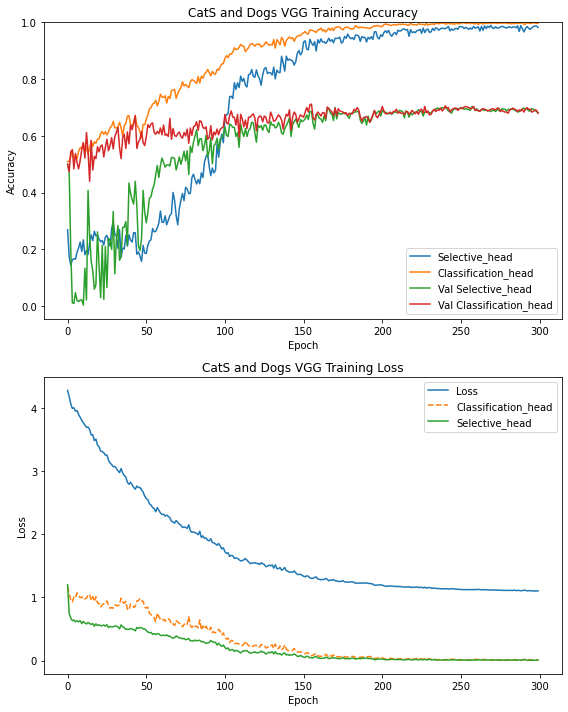

In [26]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['classification_head_accuracy'],linestyle='-', label='Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_classification_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CatS and Dogs VGG Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['classification_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
# plt.plot(x,lr_curve['val_classification_head_loss'], linestyle='--', label='Val Classification_head')
# plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
# plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CatS and Dogs VGG Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

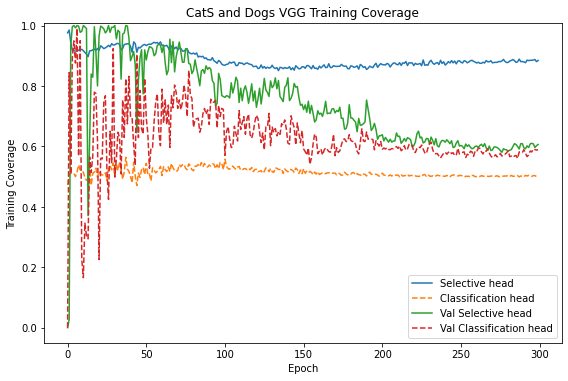

In [27]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['classification_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('CatS and Dogs VGG Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [28]:
predictions= catsdog_selectivenet.predict(test_img) #set predictions for use

In [29]:
print("Shape of classification head predictions: ",predictions[1].shape)
y_true = np.argmax(test_label,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Classification head predictions: ",y_pred.shape)      

Shape of classification head predictions:  (500, 2)
Classification head predictions:  (500,)


In [30]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Selective head Accuracy:",acc)
print("Classification head Accuracy:",aux_acc)

Selective head Accuracy: 0.68
Classification head Accuracy: 0.698


In [31]:
coverages = np.arange(0.5,1.05,0.05) # coverages
coverage_risk = np.zeros((coverages.shape[0],3), dtype = "float")
sel_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sel_coverages_risk[i]= selective_risk(c,test_label,predictions[1],predictions[0][:,-1])
    i=i+1
    
i=0
for c in coverages:
    coverage_risk[i]= sr_selective_risk(c,test_label,predictions[1],mc=True)
    i=i+1

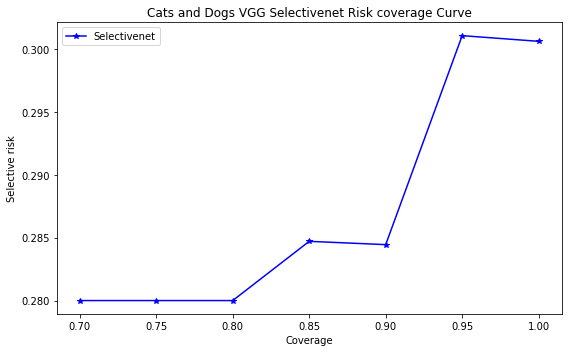

In [32]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],sel_coverages_risk[4:,1],color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Selectivenet Risk coverage Curve')
plt.tight_layout()
plt.show()

In [33]:
sel_coverages_risk

array([[0.5       , 0.212     , 0.788     ],
       [0.55      , 0.22545455, 0.77454545],
       [0.6       , 0.25333333, 0.74666667],
       [0.65      , 0.27692308, 0.72307692],
       [0.7       , 0.28      , 0.72      ],
       [0.75      , 0.28      , 0.72      ],
       [0.8       , 0.28      , 0.72      ],
       [0.85      , 0.28470588, 0.71529412],
       [0.9       , 0.28444444, 0.71555556],
       [0.95      , 0.30105263, 0.69894737],
       [0.998     , 0.3006012 , 0.6993988 ]])

### Baseline Model

In [34]:
baseline = "catsdogs_baseline_vgg.h5"

In [35]:
catsdog_selectivenet = CatsvsDogVgg(IMG_SHAPE, train_ds=train_ds, val_ds=val_ds,
                                    filename=baseline, coverage=c, alpha=alpha, train=False, baseline=True)

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [38]:
history = catsdog_selectivenet.train(catsdog_selectivenet.get_model(),train_ds,val_ds=val_ds)

In [39]:
history_header =",".join(["classification_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","classification_head_loss", "selective_head_loss", "classification_head_coverage", 
                  "selective_head_coverage","val_classification_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_classification_head_loss", "val_selective_head_loss",
                  "val_classification_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/basemodel_catdog_vgg_history.csv'
f=open(history_fname,"w")
f.write(history_header)
f.close()

In [40]:
a=np.array([
    history.history['classification_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['classification_head_loss'],
    history.history['selective_head_loss'],
    history.history['classification_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_classification_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_classification_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_classification_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

In [41]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

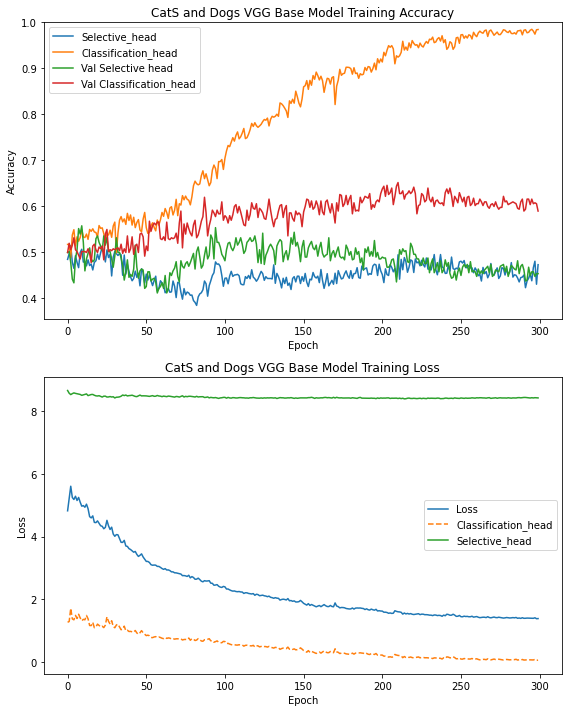

In [42]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['classification_head_accuracy'],linestyle='-', label='Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CatS and Dogs VGG Base Model Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['classification_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
# plt.plot(x,lr_curve['val_classification_head_loss'], linestyle='--', label='Val Classification_head')
# plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
# plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CatS and Dogs VGG Base Model Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

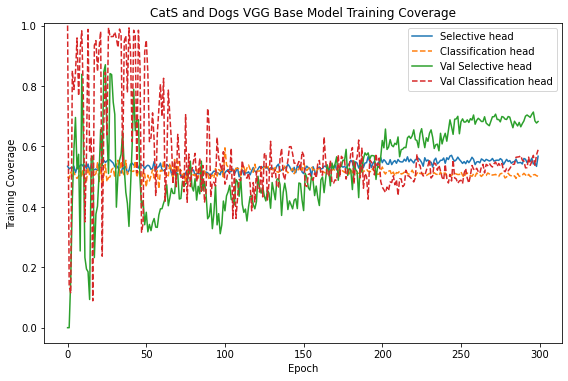

In [43]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['classification_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('CatS and Dogs VGG Base Model Training Coverage')
plt.tight_layout()
plt.show()

In [54]:
predictions= catsdog_selectivenet.predict(test_img) #set predictions for use

In [55]:
y_true = np.argmax(test_label,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("BR predictions: ",y_pred.shape)      

BR predictions:  (500,)


In [56]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
print("Selective head Accuracy:",acc)
acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Classification head Accuracy:",acc)

Selective head Accuracy: 0.44
Classification head Accuracy: 0.634


In [57]:
coverages = np.arange(0.5,1.05,0.05) # coverages
br_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    br_coverages_risk[i]= selective_risk(c,test_label,predictions[1],predictions[0][:,-1])
    i=i+1
#br_coverages_risk    

In [58]:
coverages = np.arange(0.5,1.05,0.05) # coverages
br_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    br_sr_coverages_risk[i]= sr_selective_risk(c,test_label,predictions[1],mc=True)
    i=i+1

br_sr_coverages_risk    

array([[0.498     , 0.28514056, 0.71485944],
       [0.548     , 0.30291971, 0.69708029],
       [0.598     , 0.33110368, 0.66889632],
       [0.648     , 0.35185185, 0.64814815],
       [0.698     , 0.35530086, 0.64469914],
       [0.748     , 0.35026738, 0.64973262],
       [0.798     , 0.36090226, 0.63909774],
       [0.848     , 0.35613208, 0.64386792],
       [0.898     , 0.35634744, 0.64365256],
       [0.948     , 0.3649789 , 0.6350211 ],
       [0.998     , 0.36673347, 0.63326653]])

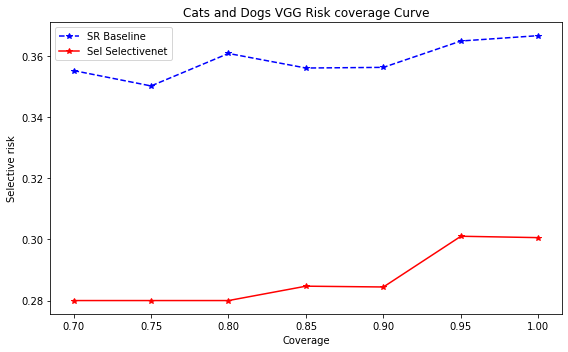

In [59]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,br_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],br_sr_coverages_risk[4:,1],color='blue', linestyle='--',marker='*',label='SR Baseline')
ax.plot(coverages[4:],sel_coverages_risk[4:,1],color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

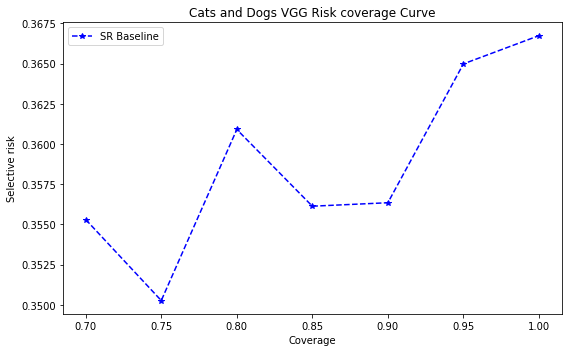

In [60]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,br_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],br_sr_coverages_risk[4:,1],color='blue', linestyle='--',marker='*',label='SR Baseline')
# ax.plot(coverages,sel_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

### SR model

In [61]:
from vgg_SR import vgg_SR_build_model

In [66]:
sr_model=vgg_SR_build_model(input_dim=IMG_SHAPE, num_classes=len(CLASS_NAMES),weight_decay=0.0005,mc_dropout_rate=0.1)

In [22]:
batch_size = 32
maxepoches = 300
# stepsperepoch=2000// batch_size
learning_rate = 0.01
lr_drop = 25
def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [68]:
historytemp = sr_model.fit(train_ds, initial_epoch=0, shuffle=True,
                          epochs=maxepoches, validation_data=val_ds, callbacks=[reduce_lr])

In [75]:
sr_model.save_weights("saved_data/{}".format('catsdogs_vgg_SR.h5'))

In [69]:
sr_model.load_weights("saved_data/{}".format('catsdogs_vgg_SR.h5'))

In [70]:
header =",".join(["accuracy", "loss","val_accuracy","val_loss\n"])
sr_history=save_dir+'/catsdogs_vgg_sr_history.csv'
# f=open(sr_history,"w")
# f.write(header)
# f.close()

In [78]:
a=np.array([
    historytemp.history['accuracy'],
    historytemp.history['loss'],
    historytemp.history['val_accuracy'],
    historytemp.history['val_loss']
]).T
write_csv(sr_history,a)

### SR learning curve

In [79]:
sr_curve=pd.read_csv(sr_history)
# sr_curve

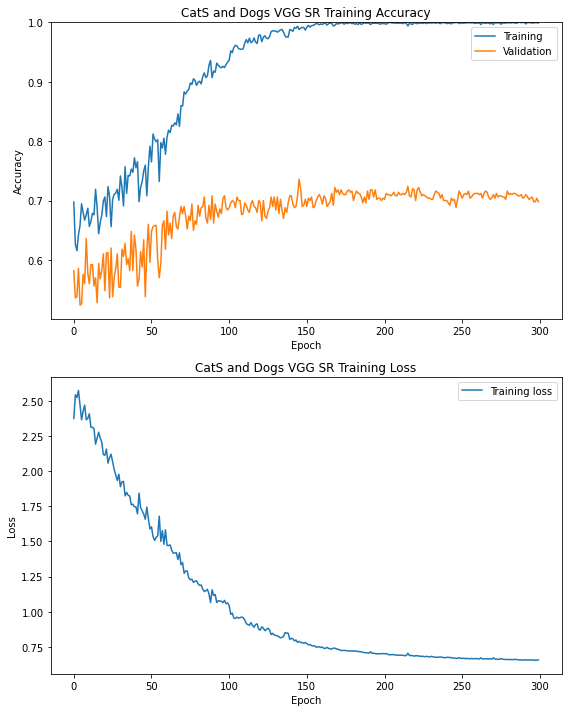

In [80]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(sr_curve.shape[0])
plt.plot(x,sr_curve['accuracy'],linestyle='-', label='Training')
plt.plot(x,sr_curve['val_accuracy'],linestyle='-', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CatS and Dogs VGG SR Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x,sr_curve['loss'], label='Training loss')
# plt.plot(x,sr_curve['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CatS and Dogs VGG SR Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [74]:
predictions= sr_model.predict(test_img) #set predictions for use

In [75]:
y_true = np.argmax(test_label,axis=1)
y_pred = np.argmax(predictions,axis=1)
print("SR predictions: ",y_pred.shape)      

SR predictions:  (500,)


In [76]:
acc=my_evaluation(y_true,np.argmax(predictions,axis=1))
print("Accuracy:",acc)

Accuracy: 0.708


In [77]:
sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sr_coverages_risk[i]= sr_selective_risk(c,test_label,predictions,mc=True)
    i=i+1
sr_coverages_risk    

array([[0.498     , 0.20080321, 0.79919679],
       [0.548     , 0.2080292 , 0.7919708 ],
       [0.598     , 0.21070234, 0.78929766],
       [0.648     , 0.22530864, 0.77469136],
       [0.698     , 0.22922636, 0.77077364],
       [0.748     , 0.24331551, 0.75668449],
       [0.798     , 0.26065163, 0.73934837],
       [0.848     , 0.26415094, 0.73584906],
       [0.898     , 0.27394209, 0.72605791],
       [0.948     , 0.28691983, 0.71308017],
       [0.998     , 0.29258517, 0.70741483]])

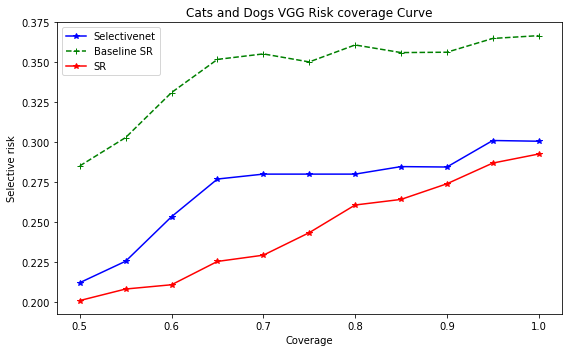

In [78]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages,sel_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,br_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages,br_sr_coverages_risk[:,1],color='green', linestyle='--',marker='+',label='Baseline SR')
ax.plot(coverages,sr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

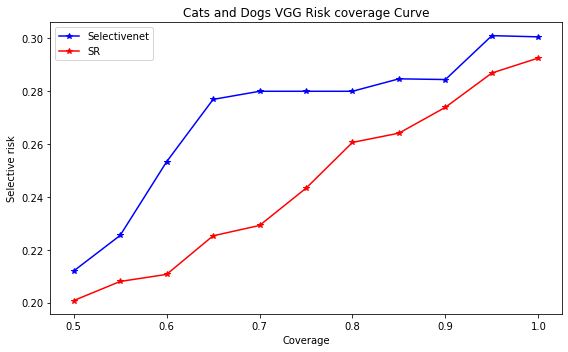

In [79]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages,sel_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,br_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages,br_sr_coverages_risk[:,1],color='green', linestyle='--',marker='+',label='Baseline SR')
ax.plot(coverages,sr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

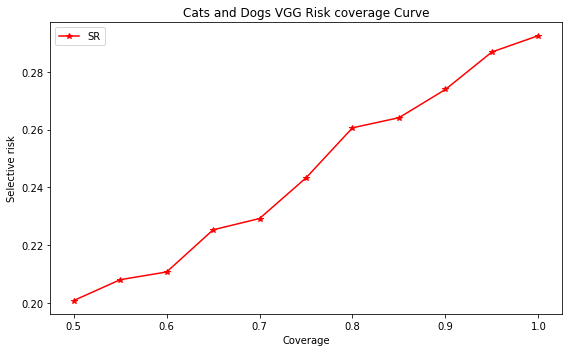

In [80]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,sel_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,coverage_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,br_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages,br_sr_coverages_risk[:,1],color='green', linestyle='--',marker='+',label='Baseline SR')
ax.plot(coverages,sr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

In [23]:
from effnet_selectivenet import *

In [28]:
dropout = 0.2
mc_dropout =0.1
training=True
pooling="avg"
input_dims=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)
learning_rate = 0.0025
momentum=0.9
initial_epoch=0
maxepoches=300
lr_decay = 1e-6
lr_drop = 50
def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [25]:
early_stop_callback=tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.0001, patience=10, restore_best_weights=True
)

In [29]:
my_selectivenet = SelectiveNet(dropout=dropout, mc_dropout = mc_dropout,num_classes=num_class,
                               training=True, input_dim=input_dims,pooling=pooling)
my_selectivenet.compile_model(c=c,lr=learning_rate,decay=lr_decay,alpha=0.5)

In [ ]:
history = my_selectivenet.model_train(train_ds=train_ds, val_ds=val_ds, EPOCHS=maxepoches, initial_epoch=initial_epoch, shuffle=False, 
                                      verbose=1,callbacks=[reduce_lr,early_stop_callback])

In [31]:
save_dir='saved_data'
history_header =",".join(["auxilary_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","auxilary_head_loss", "selective_head_loss", "auxilary_head_coverage", 
                  "selective_head_coverage","val_auxilary_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_auxilary_head_loss", "val_selective_head_loss",
                  "val_auxilary_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/catsdogs_effnet_history.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [32]:
a=np.array([
    history.history['auxilary_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['auxilary_head_loss'],
    history.history['selective_head_loss'],
    history.history['auxilary_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_auxilary_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_auxilary_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_auxilary_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [33]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

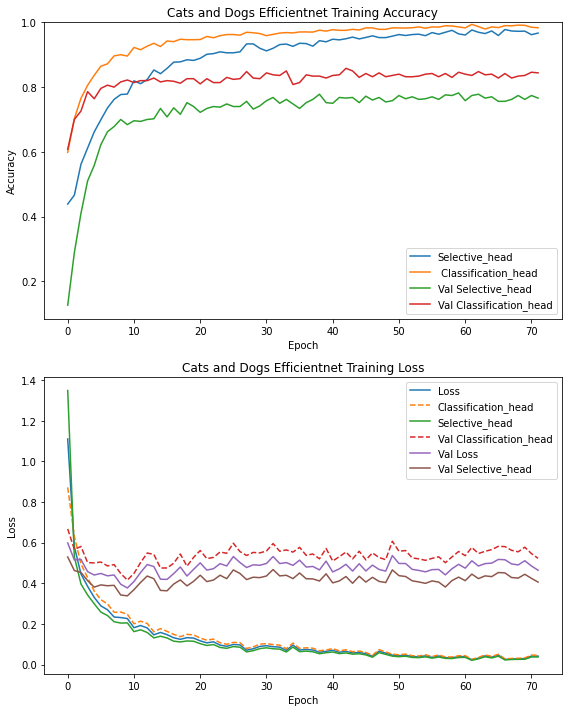

In [34]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['auxilary_head_accuracy'],linestyle='-', label=' Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Cats and Dogs Efficientnet Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['auxilary_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_loss'], linestyle='--', label='Val Classification_head')
plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Cats and Dogs Efficientnet Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

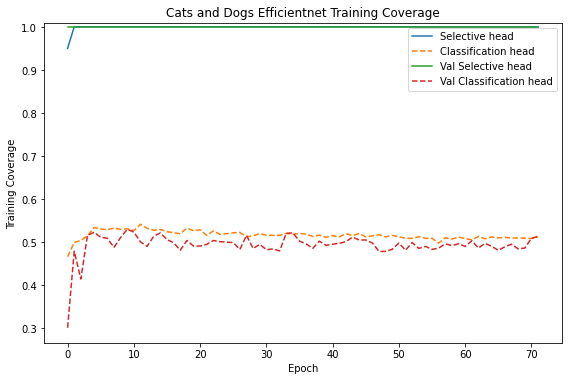

In [35]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['auxilary_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_auxilary_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Cats and Dogs Efficientnet Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [37]:
my_selectivenet.get_model().save_weights(save_dir+'/effnet_sel_model.h5')

In [38]:
# my_selectivenet.set_model_weights(save_dir+'/effnet_sel_model.h5')

In [39]:
# gpredictions = my_selectivenet.selective_predict(test_img)
predictions = my_selectivenet.classification_predict(test_img) #set predictions for use    

In [40]:
print("Shape of selective head predictions: ",predictions[0].shape)
y_true = np.argmax(test_label,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Selective head predictions: ",y_pred.shape)      

Shape of selective head predictions:  (500, 3)
Selective head predictions:  (500,)


In [41]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Accuracy:",acc)
print("Classification Accuracy:",aux_acc)

Accuracy: 0.794
Classification Accuracy: 0.882


In [42]:
coverages = np.arange(0.5,1.05,0.05) # coverages
esel_coverage_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esel_coverage_risk[i] = selective_risk(c,test_label,predictions[1],predictions[0][:,-1]) #coverage_risk[0]
    i=i+1

esel_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esel_sr_coverages_risk[i]= sr_selective_risk(c,test_label,predictions[0],mc=True)
    i=i+1
esel_coverage_risk    

array([[0.5       , 0.084     , 0.916     ],
       [0.55      , 0.09090909, 0.90909091],
       [0.6       , 0.09      , 0.91      ],
       [0.65      , 0.09538462, 0.90461538],
       [0.7       , 0.1       , 0.9       ],
       [0.75      , 0.10666667, 0.89333333],
       [0.8       , 0.105     , 0.895     ],
       [0.85      , 0.10588235, 0.89411765],
       [0.9       , 0.10666667, 0.89333333],
       [0.95      , 0.11368421, 0.88631579],
       [0.998     , 0.11823647, 0.88176353]])

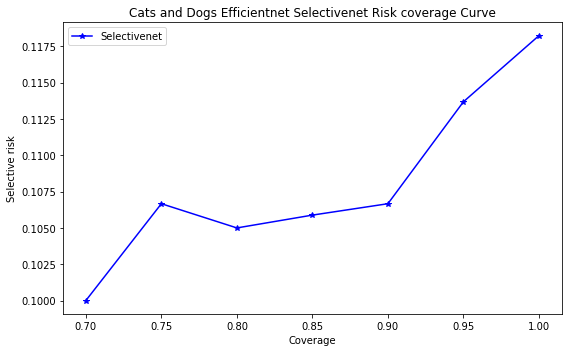

In [43]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],esel_coverage_risk[4:,1],color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='Classification head')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs Efficientnet Selectivenet Risk coverage Curve')
plt.tight_layout()
plt.show()

In [44]:
my_selectivenet = SelectiveNet(dropout=0.4, mc_dropout = 0.1,num_classes=num_class,
                               training=training, input_dim=input_dims,pooling=pooling)
my_selectivenet.compile_model(c=c,lr=learning_rate,decay=lr_decay,alpha=0.0)

In [45]:
# my_selectivenet.get_model().summary()

In [61]:
history = my_selectivenet.model_train(train_ds=train_ds, val_ds=val_ds, EPOCHS=maxepoches, initial_epoch=initial_epoch, shuffle=True, 
                                      verbose=1, callbacks = [reduce_lr,early_stop_callback])

In [47]:
history_header =",".join(["auxilary_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","auxilary_head_loss", "selective_head_loss", "auxilary_head_coverage", 
                  "selective_head_coverage","val_auxilary_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_auxilary_head_loss", "val_selective_head_loss",
                  "val_auxilary_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/catsdogs_basemodel_effnet_history.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [48]:
a=np.array([
    history.history['auxilary_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['auxilary_head_loss'],
    history.history['selective_head_loss'],
    history.history['auxilary_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_auxilary_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_auxilary_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_auxilary_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [49]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

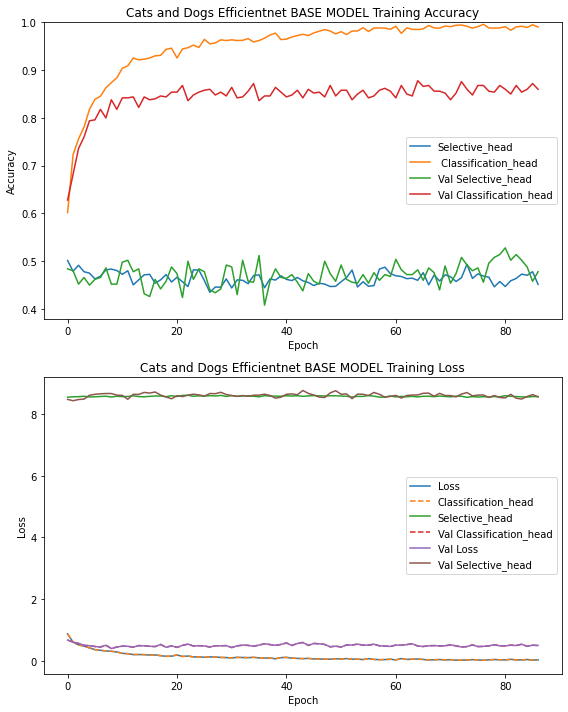

In [50]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['auxilary_head_accuracy'],linestyle='-', label=' Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Cats and Dogs Efficientnet BASE MODEL Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['auxilary_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_loss'], linestyle='--', label='Val Classification_head')
plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Cats and Dogs Efficientnet BASE MODEL Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

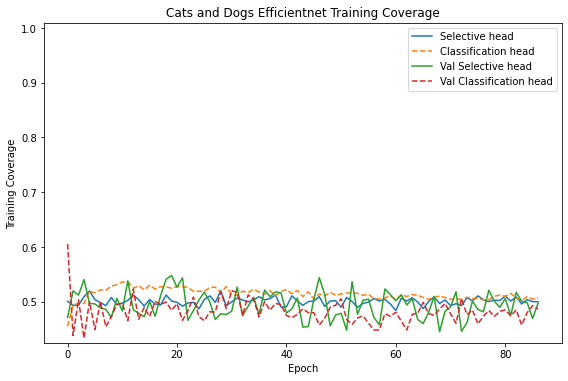

In [51]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['auxilary_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_auxilary_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Cats and Dogs Efficientnet Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [52]:
my_selectivenet.get_model().save_weights(save_dir+'/catsdogs_effnet_base_model.h5')

In [53]:
# my_selectivenet.get_model().save_weights(save_dir+'/catsdogs_effnet_base_model.h5')

In [54]:
predictions = my_selectivenet.classification_predict(test_img) #set predictions for use    

In [55]:
print("Shape of selective head predictions: ",predictions[0].shape)
y_true = np.argmax(test_label,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Selective head predictions: ",y_pred.shape)      

Shape of selective head predictions:  (500, 3)
Selective head predictions:  (500,)


In [57]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("BR Accuracy:",acc)
print("BR Classification Accuracy:",aux_acc)

BR Accuracy: 0.462
BR Classification Accuracy: 0.856


In [59]:
coverages = np.arange(0.5,1.05,0.05) # coverages
ebr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    ebr_coverages_risk[i]= selective_risk(c,test_label,predictions[1],predictions[0][:,-1])
    i=i+1

ebr_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    ebr_sr_coverages_risk[i]= sr_selective_risk(c,test_label,predictions[1],mc=True)
    i=i+1
ebr_sr_coverages_risk    

array([[0.498     , 0.02811245, 0.97188755],
       [0.548     , 0.03284672, 0.96715328],
       [0.598     , 0.04013378, 0.95986622],
       [0.648     , 0.04938272, 0.95061728],
       [0.698     , 0.05730659, 0.94269341],
       [0.748     , 0.06149733, 0.93850267],
       [0.798     , 0.0726817 , 0.9273183 ],
       [0.848     , 0.08018868, 0.91981132],
       [0.898     , 0.0935412 , 0.9064588 ],
       [0.948     , 0.12025316, 0.87974684],
       [0.998     , 0.14428858, 0.85571142]])

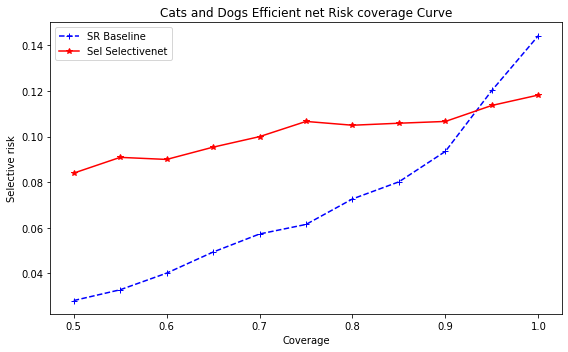

In [60]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,ebr_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages,ebr_sr_coverages_risk[:,1],color='blue', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages,esel_coverage_risk[:,1],color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

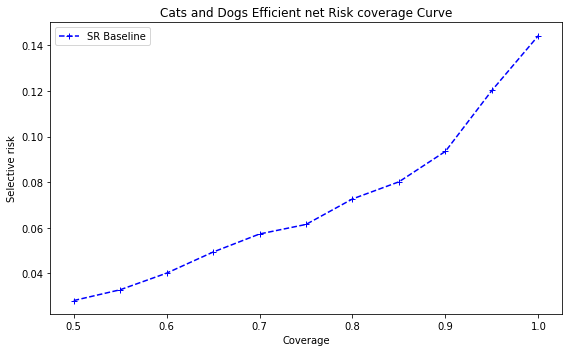

In [62]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,ebr_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages,ebr_sr_coverages_risk[:,1],color='blue', linestyle='--',marker='+',label='SR Baseline')
# ax.plot(coverages,esel_coverage_risk[:,1],color='red', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and Dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

### SR model

In [63]:
from effnet_SR import SR_model

In [64]:
sr_model=SR_model(num_classes=len(CLASS_NAMES),dropout=dropout,mc_dropout=mc_dropout,input_dim=IMG_SHAPE,training=True)

In [65]:
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=momentum, nesterov=True)
sr_model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [80]:
historytemp = sr_model.fit(train_ds, epochs=maxepoches,validation_data=val_ds, callbacks=[reduce_lr,early_stop_callback])

In [67]:
sr_model.save_weights("saved_data/{}".format('catsdogs_effnet_SR.h5'))

In [68]:
header =",".join(["accuracy","loss","val_accuracy", "val_loss\n"])
sr_history=save_dir+'/catsdogs_effnet_sr_history.csv'
f=open(sr_history,"w")
f.write(header)
f.close()

In [69]:
a=np.array([
    historytemp.history['accuracy'],
    historytemp.history['loss'],
    historytemp.history['val_accuracy'],
    historytemp.history['val_loss']
]).T
write_csv(sr_history,a)

### SR learning curve

In [70]:
sr_curve=pd.read_csv(sr_history)

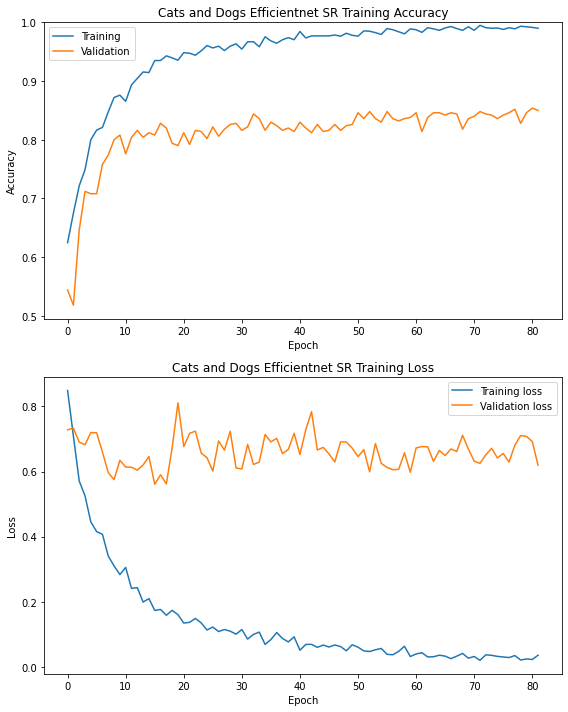

In [71]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(sr_curve.shape[0])
plt.plot(x,sr_curve['accuracy'],linestyle='-', label='Training')
plt.plot(x,sr_curve['val_accuracy'],linestyle='-', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Cats and Dogs Efficientnet SR Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x,sr_curve['loss'], label='Training loss')
plt.plot(x,sr_curve['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Cats and Dogs Efficientnet SR Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [72]:
predictions= sr_model.predict(test_img) #set predictions for use

In [73]:
y_true = np.argmax(test_label,axis=1)
y_pred = np.argmax(predictions,axis=1)
print("SR predictions: ",y_pred.shape)      

SR predictions:  (500,)


In [74]:
acc=my_evaluation(y_true,np.argmax(predictions,axis=1))
print("Accuracy:",acc)

Accuracy: 0.868


In [75]:
esr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esr_coverages_risk[i]= sr_selective_risk(c,test_label,predictions,mc=True)
    i=i+1

In [76]:
esr_coverages_risk

array([[0.498     , 0.03212851, 0.96787149],
       [0.548     , 0.03284672, 0.96715328],
       [0.598     , 0.03010033, 0.96989967],
       [0.648     , 0.0462963 , 0.9537037 ],
       [0.698     , 0.05730659, 0.94269341],
       [0.748     , 0.07486631, 0.92513369],
       [0.798     , 0.0877193 , 0.9122807 ],
       [0.848     , 0.09669811, 0.90330189],
       [0.898     , 0.10690423, 0.89309577],
       [0.948     , 0.11814346, 0.88185654],
       [0.998     , 0.13226453, 0.86773547]])

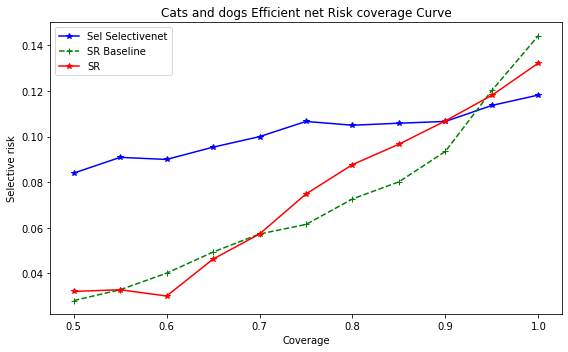

In [77]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages,esel_coverage_risk[:,1],color='blue', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,ebr_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages,ebr_sr_coverages_risk[:,1],color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages,esr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

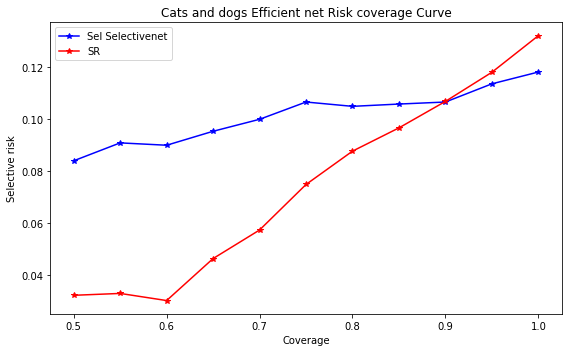

In [78]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages,esel_coverage_risk[:,1],color='blue', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,ebr_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages,ebr_sr_coverages_risk[:,1],color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages,esr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()

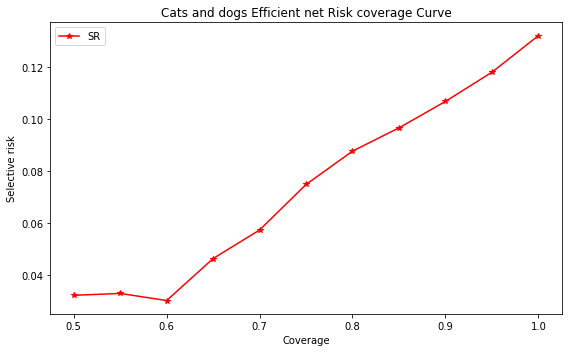

In [79]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,esel_coverage_risk[:,1],color='blue', linestyle='-',marker='*',label='Sel Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,ebr_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
# ax.plot(coverages,ebr_sr_coverages_risk[:,1],color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages,esr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cats and dogs Efficient net Risk coverage Curve')
plt.tight_layout()
plt.show()